## **Data Loading**

In [ ]:
import gdown
drive_link = 'https://drive.google.com/file/d/1-1vVh7moyW_eBKl_GL-TDILl-LnqMYk0/view?usp=sharing'

file_id = drive_link.split('/d/')[1].split('/')[0]
gdown_url = f'https://drive.google.com/uc?id={file_id}'

output_file = 'sepsis_data.csv'
gdown.download(gdown_url, output_file, quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=1-1vVh7moyW_eBKl_GL-TDILl-LnqMYk0
From (redirected): https://drive.google.com/uc?id=1-1vVh7moyW_eBKl_GL-TDILl-LnqMYk0&confirm=t&uuid=d7ff50c3-a6e0-44d0-9eb7-aa26a6afc29e
To: /kaggle/working/sepsis_data.csv
100%|██████████| 779M/779M [00:08<00:00, 91.5MB/s] 


'sepsis_data.csv'

## **Imports**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
import numpy as np
import pandas as pd
from tqdm import tqdm

# Scikit-learn modules
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.tree import plot_tree


# TensorFlow / Keras modules
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, LSTM, GRU, Dense, Dropout, Bidirectional,
    TimeDistributed, BatchNormalization, GlobalAveragePooling1D
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from IPython.display import display, clear_output
import ipywidgets as widgets


np.random.seed(42)
tf.random.set_seed(42)
warnings.filterwarnings('ignore')


2025-05-03 05:29:04.953488: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746250145.166931      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746250145.224759      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
!pip install --upgrade scikit-learn
!pip install --upgrade imbalanced-learn


# **============================================================================================**

## **Sampling & Model & Evaluation Functions**

In [ ]:

def load_and_preprocess_data(filepath):
    """Load and clean data with memory-efficient datatypes"""
    print("\n[STEP 1] Loading data...")
    # Read column names first to set datatypes efficiently
    dtype_dict = {col: 'float32' for col in pd.read_csv(filepath, nrows=1).columns
                if col not in ['Patient_ID', 'SepsisLabel', 'ICULOS']}
    dtype_dict.update({'Patient_ID': 'str', 'SepsisLabel': 'int8', 'ICULOS': 'int16'})

    # Use chunks for more memory-efficient loading of large files
    df = pd.read_csv(filepath, dtype=dtype_dict)
    df = df.sort_values(['Patient_ID', 'ICULOS'])

    # Handle missing values - simplified approach
    cols_to_impute = [col for col in df.columns if col not in ['Patient_ID', 'SepsisLabel', 'ICULOS']]

    # First forward fill within patient groups
    df[cols_to_impute] = df.groupby('Patient_ID')[cols_to_impute].transform(lambda x: x.ffill())

    # Then backward fill remaining values
    df[cols_to_impute] = df.groupby('Patient_ID')[cols_to_impute].transform(lambda x: x.bfill())

    # Finally fill any remaining NaNs with 0
    df[cols_to_impute] = df[cols_to_impute].fillna(0)

    print("Initial class distribution:")
    print(df['SepsisLabel'].value_counts())
    return df

# Create patient sequences
def create_patient_sequences(df, sequence_length=10):
    """Create sequences with memory-efficient implementation"""
    print(f"\n[STEP 2] Creating sequences (length={sequence_length})...")
    # Pre-allocate lists for efficiency
    sequences = []
    labels = []

    # Select only needed columns for feature extraction
    feature_cols = [col for col in df.columns if col not in ['Patient_ID', 'SepsisLabel', 'ICULOS']]

    # Process patients one by one to manage memory
    for pid, group in df.groupby('Patient_ID'):
        # Extract features and labels
        features = group[feature_cols].values
        sepsis_labels = group['SepsisLabel'].values

        # Handle sequences shorter than desired length
        if len(features) < sequence_length:
            # Pad with zeros at the beginning (representing historical data we don't have)
            pad_len = sequence_length - len(features)
            features = np.vstack([np.zeros((pad_len, features.shape[1])), features])
            sepsis_labels = np.concatenate([np.zeros(pad_len), sepsis_labels])

        # Create sliding windows - optimized to avoid unnecessary operations
        for i in range(0, len(features) - sequence_length + 1, 1):  # Step size of 1
            seq = features[i:i+sequence_length]
            # Label as 1 if sepsis occurs within the sequence window
            label = 1 if np.any(sepsis_labels[i:i+sequence_length] > 0) else 0
            sequences.append(seq)
            labels.append(label)

    # Convert to numpy arrays for TensorFlow compatibility
    X = np.array(sequences, dtype=np.float32)  # Explicit dtype
    y = np.array(labels, dtype=np.int8)  # Explicit dtype

    print(f"Created {len(X)} sequences")
    print(f"Class 0: {np.sum(y == 0)}, Class 1: {np.sum(y == 1)}")
    return X, y, feature_cols

#  Decision Tree based undersampling
def decision_tree_undersampling(X, y, target_samples=35000):
    print(f"\nUndersampling majority class to {target_samples} samples...")

    # Get indices of majority class
    majority_indices = np.where(y == 0)[0]

    # If we already have fewer samples than target, return as is
    if len(majority_indices) <= target_samples:
        return X, y

    # Randomly select subset for efficiency
    np.random.shuffle(majority_indices)
    subset_indices = majority_indices[:min(50000, len(majority_indices))]  # Limit for efficiency

    # Flatten the time steps for feature importance calculation
    X_flattened = X[subset_indices].reshape(-1, X.shape[-1])
    y_flattened = np.repeat(y[subset_indices], X.shape[1])

    # Train decision tree to find most important samples
    dt = DecisionTreeClassifier(max_depth=5, random_state=42)
    dt.fit(X_flattened, y_flattened)

    # Get feature importances for each sample
    sample_importances = []
    for idx in subset_indices:
        # Calculate average feature importance across all time steps
        importance = np.mean([dt.feature_importances_ for _ in range(X.shape[1])], axis=0)
        sample_importances.append(np.sum(importance))

    # Select samples with highest importance scores
    selected_indices = np.argsort(sample_importances)[-target_samples:]

    # Combine with minority class
    minority_indices = np.where(y == 1)[0]
    final_indices = np.concatenate([subset_indices[selected_indices], minority_indices])

    return X[final_indices], y[final_indices]

#  Decision Tree based upsampling
def decision_tree_upsampling(X, y, target_samples=27000):
    print(f"\nUpsampling minority class to {target_samples} samples...")

    # Get indices of minority class
    minority_indices = np.where(y == 1)[0]

    # If we already have more samples than target, return as is
    if len(minority_indices) >= target_samples:
        return X, y

    # Calculate how many samples we need to generate
    num_to_generate = target_samples - len(minority_indices)

    # Flatten the time steps for feature importance calculation
    X_flattened = X.reshape(-1, X.shape[-1])
    y_flattened = np.repeat(y, X.shape[1])

    # Train decision tree to understand feature relationships
    dt = DecisionTreeClassifier(max_depth=5, random_state=42)
    dt.fit(X_flattened, y_flattened)

    # Generate synthetic samples based on feature distributions
    synthetic_samples = []
    for _ in range(num_to_generate):
        # Randomly select a minority sample to base new sample on
        base_sample = X[np.random.choice(minority_indices)]

        # Create synthetic sample by perturbing features based on importance
        synthetic_sample = base_sample.copy()
        for t in range(X.shape[1]):  # For each time step
            for f in range(X.shape[2]):  # For each feature
                if dt.feature_importances_[f] > 0.01:  # Only modify important features
                    # Add noise proportional to feature importance
                    noise = np.random.normal(0, dt.feature_importances_[f] * 0.1)
                    synthetic_sample[t, f] += noise

        synthetic_samples.append(synthetic_sample)

    # Convert list of synthetic samples to numpy array with same shape as X
    synthetic_samples = np.array(synthetic_samples)

    # Combine real and synthetic samples
    X_upsampled = np.concatenate([X, synthetic_samples])
    y_upsampled = np.concatenate([y, np.ones(num_to_generate, dtype=np.int8)])

    return X_upsampled, y_upsampled

# Prepare balanced dataset
def prepare_balanced_dataset(X, y, target_class0=35000, target_class1=27000):
    """Create a balanced dataset through undersampling majority class and oversampling minority class

    Parameters:
        X: Input features (numpy array)
        y: Target labels (numpy array)
        target_class0: Desired number of samples for class 0
        target_class1: Desired number of samples for class 1

    Returns:
        X_balanced: Balanced feature matrix
        y_balanced: Balanced target vector
    """
    print("\n[STEP 3] Preparing balanced dataset...")

    # First, undersample class 0 to exact target
    X_undersampled, y_undersampled = decision_tree_undersampling(X, y, target_samples=target_class0)

    # Then, upsample class 1 to exact target
    X_balanced, y_balanced = decision_tree_upsampling(X_undersampled, y_undersampled, target_samples=target_class1)

    # Shuffle the dataset
    indices = np.arange(len(y_balanced))
    np.random.shuffle(indices)
    X_balanced = X_balanced[indices]
    y_balanced = y_balanced[indices]

    print(f"Final balanced dataset - Class 0: {np.sum(y_balanced == 0)}, Class 1: {np.sum(y_balanced == 1)}")
    return X_balanced, y_balanced
# Train-test split
def custom_train_test_split_with_balancing(X, y, train_class0=35000, train_class1=27000):
    """Custom train-test split that maintains exact class balance in both sets

    Parameters:
        X: Input features (numpy array)
        y: Target labels (numpy array)
        train_class0: Desired number of class 0 samples in training set
        train_class1: Desired number of class 1 samples in training set

    Returns:
        X_train, X_test, y_train, y_test: Split datasets with exact class balance
    """
    print("\n[STEP 4] Custom train-test split with balanced classes...")

    # Get indices for each class
    indices_class0 = np.where(y == 0)[0]
    indices_class1 = np.where(y == 1)[0]

    print(f"Total samples - Class 0: {len(indices_class0)}, Class 1: {len(indices_class1)}")

    # Make sure we don't request more samples than available
    train_class0 = min(train_class0, len(indices_class0))
    train_class1 = min(train_class1, len(indices_class1))

    # Randomly select indices for training set for each class
    np.random.shuffle(indices_class0)
    np.random.shuffle(indices_class1)

    train_indices_class0 = indices_class0[:train_class0]
    train_indices_class1 = indices_class1[:train_class1]

    # Remaining indices go to test set
    test_indices_class0 = indices_class0[train_class0:]
    test_indices_class1 = indices_class1[train_class1:]

    # Combine indices
    train_indices = np.concatenate([train_indices_class0, train_indices_class1])
    test_indices = np.concatenate([test_indices_class0, test_indices_class1])

    # Shuffle the training indices
    np.random.shuffle(train_indices)

    # Create the training and test sets
    X_train = X[train_indices]
    y_train = y[train_indices]
    X_test = X[test_indices]
    y_test = y[test_indices]

    print(f"Training set - Class 0: {np.sum(y_train == 0)}, Class 1: {np.sum(y_train == 1)}")
    print(f"Test set - Class 0: {np.sum(y_test == 0)}, Class 1: {np.sum(y_test == 1)}")

    return X_train, X_test, y_train, y_test
def build_bilstm(input_shape):
    inputs = Input(shape=input_shape)

    x = Bidirectional(LSTM(64, return_sequences=True))(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    x = Bidirectional(LSTM(32, return_sequences=True))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    x = GlobalAveragePooling1D()(x)

    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

    return model


def evaluate_model(model, X, y, set_name="Test"):
    """Evaluate model performance"""
    print(f"\n{set_name} Set Evaluation:")

    y_prob = model.predict(X)
    y_pred = (y_prob > 0.5).astype(int)


    print(classification_report(y, y_pred))

    auc = roc_auc_score(y, y_prob)
    print(f"ROC AUC: {auc:.4f}")

    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=['No Sepsis', 'Sepsis'],
               yticklabels=['No Sepsis', 'Sepsis'])
    plt.title(f'Confusion Matrix - {set_name} Set')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [ ]:
 filepath = "/kaggle/working/sepsis_data.csv"
df = load_and_preprocess_data(filepath)


[STEP 1] Loading data...
Initial class distribution:
SepsisLabel
0    1510640
1      26715
Name: count, dtype: int64


In [ ]:
df.columns

Index(['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'BaseExcess',
       'FiO2', 'pH', 'PaCO2', 'BUN', 'Calcium', 'Creatinine', 'Glucose',
       'Magnesium', 'Potassium', 'Hct', 'Hgb', 'WBC', 'Platelets', 'Age',
       'Gender', 'HospAdmTime', 'ICULOS', 'SepsisLabel', 'Patient_ID',
       'EtCO2_measured', 'HCO3_measured', 'SaO2_measured', 'AST_measured',
       'Alkalinephos_measured', 'Chloride_measured',
       'Bilirubin_direct_measured', 'Lactate_measured', 'Phosphate_measured',
       'Bilirubin_total_measured', 'TroponinI_measured', 'PTT_measured',
       'Fibrinogen_measured', 'Temp_observed', 'BaseExcess_observed',
       'FiO2_observed', 'pH_observed', 'PaCO2_observed', 'BUN_observed',
       'Calcium_observed', 'Creatinine_observed', 'Glucose_observed',
       'Magnesium_observed', 'Potassium_observed', 'Hct_observed',
       'Hgb_observed', 'WBC_observed', 'Platelets_observed', 'Unit1_observed',
       'Unit2_observed', 'DBP_measured'],
      dtype='object')

In [ ]:
cols_to_drop = ['Unit2_observed', 'Unit1_observed', 'HospAdmTime','Age']
existing_cols = [col for col in cols_to_drop if col in df.columns]

if existing_cols:
    df = df.drop(columns=existing_cols)
else:
    print("None of these columns exist in the DataFrame")

In [ ]:

X, y, feature_cols = create_patient_sequences(df, sequence_length=10)


[STEP 2] Creating sequences (length=10)...
Created 1179170 sequences
Class 0: 1157517, Class 1: 21653


In [ ]:
X_balanced, y_balanced = prepare_balanced_dataset(X, y, target_class0=50022, target_class1=35000)
X_train, X_test, y_train, y_test = custom_train_test_split_with_balancing(X_balanced, y_balanced, train_class0=35000, train_class1=27000)


[STEP 3] Preparing balanced dataset...

Undersampling majority class to 50022 samples...

Upsampling minority class to 35000 samples...
Final balanced dataset - Class 0: 50000, Class 1: 35000

[STEP 4] Custom train-test split with balanced classes...
Total samples - Class 0: 50000, Class 1: 35000
Training set - Class 0: 35000, Class 1: 27000
Test set - Class 0: 15000, Class 1: 8000


In [ ]:

    # # Step 5: Feature scaling
    # print("\n[STEP 5] Scaling features...")
    # scaler = StandardScaler()
    # # Reshape for scaling and back
    # X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
    # X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)


[STEP 5] Scaling features...


## **Training**

In [ ]:
print("\n[STEP 6] Building model...")
model = build_bilstm((X_train.shape[1], X_train.shape[2]))
model.summary()


print("\n[STEP 7] Training model...")
callbacks = [
        EarlyStopping(monitor='val_auc', patience=5, mode='max', restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
    ]

history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=20,
        batch_size=64,
        callbacks=callbacks,
        class_weight={0:1, 1: 1.5},
        verbose=1
    )


[STEP 6] Building model...


I0000 00:00:1746250440.586438      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 10, 51)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 10, 128)             │          59,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 10, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 10, 64)              │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 10, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 10, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 64)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 107,649 (420.50 KB)

 Trainable params: 107,265 (419.00 KB)

 Non-trainable params: 384 (1.50 KB)


[STEP 7] Training model...
Epoch 1/20


I0000 00:00:1746250449.559728     100 cuda_dnn.cc:529] Loaded cuDNN version 90300


969/969 ━━━━━━━━━━━━━━━━━━━━ 23s 13ms/step - accuracy: 0.6671 - auc: 0.7363 - loss: 0.7284 - val_accuracy: 0.7074 - val_auc: 0.8138 - val_loss: 0.5674 - learning_rate: 0.0010
Epoch 2/20
969/969 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.7334 - auc: 0.8151 - loss: 0.6370 - val_accuracy: 0.7368 - val_auc: 0.8350 - val_loss: 0.5202 - learning_rate: 0.0010
Epoch 3/20
969/969 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.7587 - auc: 0.8434 - loss: 0.5906 - val_accuracy: 0.7419 - val_auc: 0.8594 - val_loss: 0.5080 - learning_rate: 0.0010
Epoch 4/20
969/969 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.7773 - auc: 0.8686 - loss: 0.5437 - val_accuracy: 0.7706 - val_auc: 0.8785 - val_loss: 0.4669 - learning_rate: 0.0010
Epoch 5/20
969/969 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.8035 - auc: 0.8909 - loss: 0.4950 - val_accuracy: 0.7851 - val_auc: 0.8911 - val_loss: 0.4430 - learning_rate: 0.0010
Epoch 6/20
969/969 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.8238 - auc: 0

## **Evaluation**


[STEP 8] Plotting training metrics...


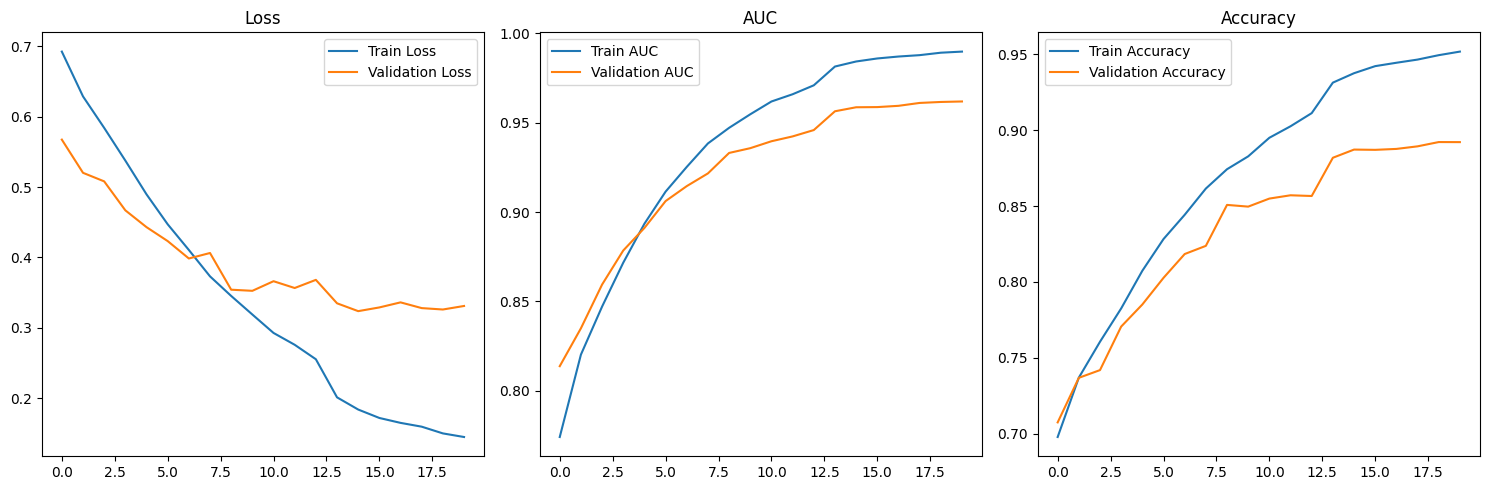


[STEP 9] Evaluating model...

Train Set Evaluation:
1938/1938 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     35000
           1       0.94      0.99      0.97     27000

    accuracy                           0.97     62000
   macro avg       0.97      0.97      0.97     62000
weighted avg       0.97      0.97      0.97     62000

ROC AUC: 0.9966


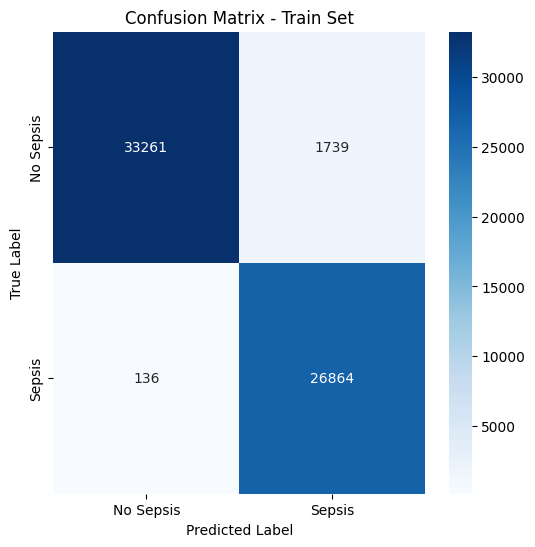


Test Set Evaluation:
719/719 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
              precision    recall  f1-score   support

           0       0.98      0.85      0.91     15000
           1       0.78      0.97      0.86      8000

    accuracy                           0.89     23000
   macro avg       0.88      0.91      0.89     23000
weighted avg       0.91      0.89      0.89     23000

ROC AUC: 0.9631


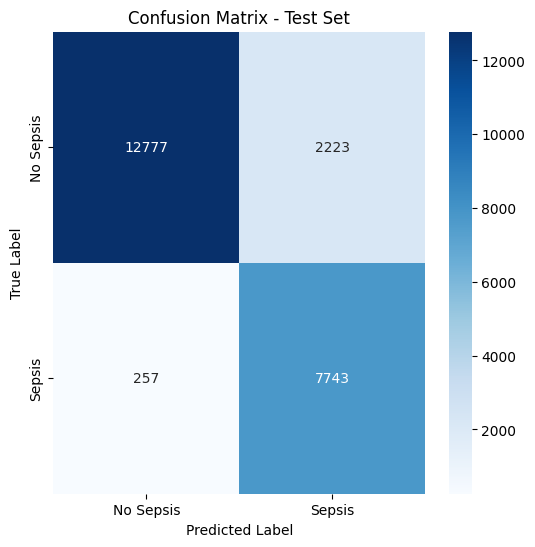

In [ ]:
 print("\n[STEP 8] Plotting training metrics...")
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.title('AUC')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

    # Step 9: Evaluate model
print("\n[STEP 9] Evaluating model...")
evaluate_model(model, X_train, y_train, "Train")
evaluate_model(model, X_test, y_test, "Test")

## **Explaination**

### **Glopal Surrogate Model Agnostic**

In [ ]:
train_predictions = model.predict(X_train)
train_predictions_class = (train_predictions > 0.5).astype(int)
surrogate_model = DecisionTreeClassifier(max_depth=5)
surrogate_model.fit(X_train.reshape(X_train.shape[0], -1), train_predictions_class)


1938/1938 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


DecisionTreeClassifier(max_depth=5)

In [ ]:
X_train.shape

(62000, 10, 55)

In [ ]:
df['BaseExcess_observed']

317787     0.0
317788     0.0
317789     0.0
317790     1.0
317791     0.0
          ... 
1334160    0.0
1334161    0.0
1334162    0.0
1334163    0.0
1334164    0.0
Name: BaseExcess_observed, Length: 1537355, dtype: float32

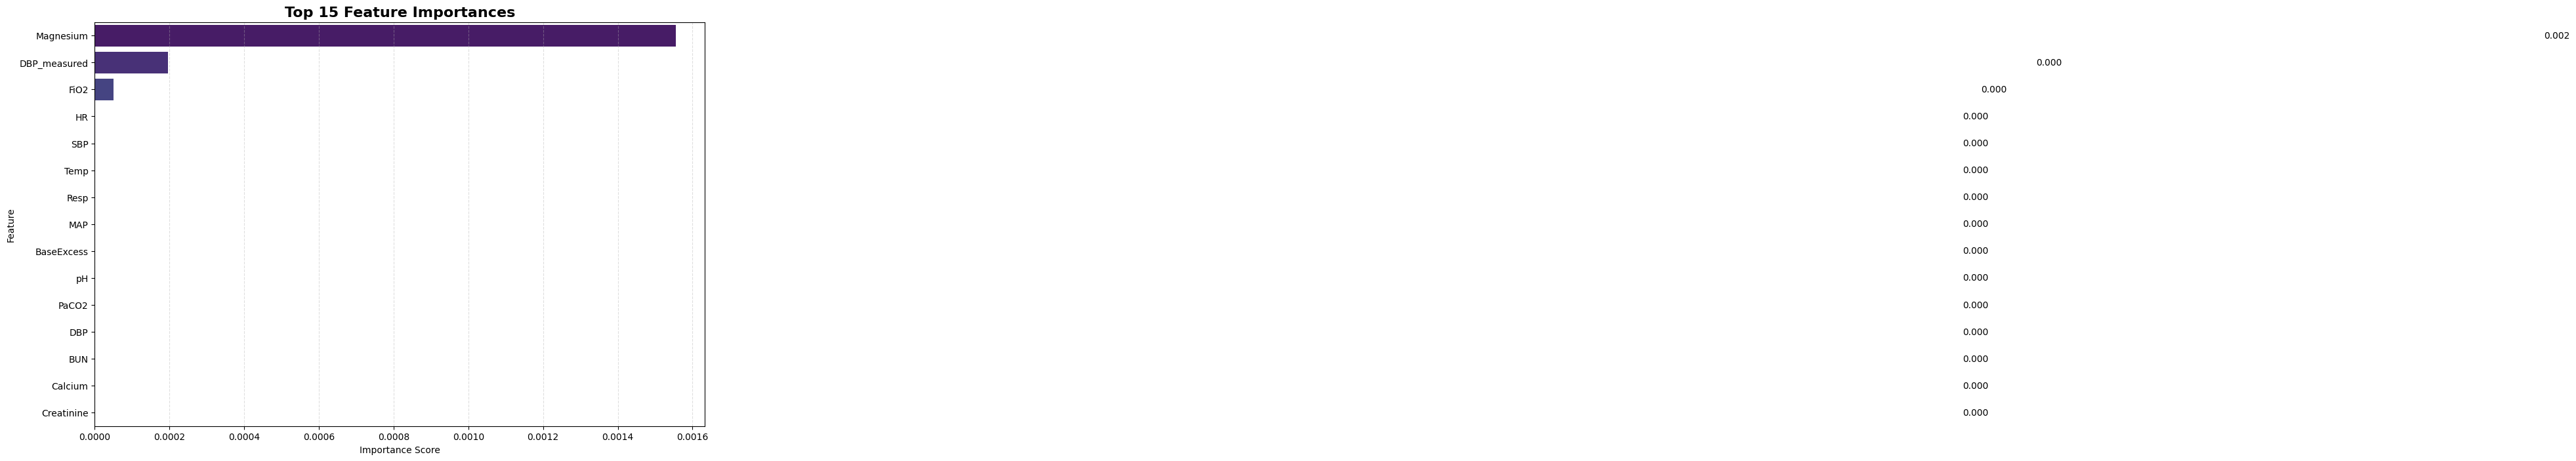

In [ ]:

feature_importance = surrogate_model.feature_importances_
try:
    if 'df' in locals() or 'df' in globals():
        feature_cols = [col for col in df.columns if col not in ['Patient_ID', 'SepsisLabel']]
    elif 'feature_cols' in locals() or 'feature_cols' in globals():
        feature_cols = feature_cols
    else:
        feature_cols = [f'Feature_{i}' for i in range(len(feature_importance))]

    # Fix mismatch
    min_len = min(len(feature_cols), len(feature_importance))
    feature_cols = feature_cols[:min_len]
    feature_importance = feature_importance[:min_len]

except Exception as e:
    print(f"Using fallback feature names due to error: {e}")
    feature_cols = [f'F{i}' for i in range(len(feature_importance))]

importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

top_n = min(15, len(importance_df))

plt.figure(figsize=(12, 8))
ax = sns.barplot(x='Importance', y='Feature',
                 data=importance_df.head(top_n),
                 palette='viridis', saturation=0.9)

for i, (_, row) in enumerate(importance_df.head(top_n).iterrows()):
    ax.text(row['Importance'] + 0.005, i, f"{row['Importance']:.3f}",
            va='center', fontsize=10)

plt.title(f'Top {top_n} Feature Importances', fontsize=16, weight='bold')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


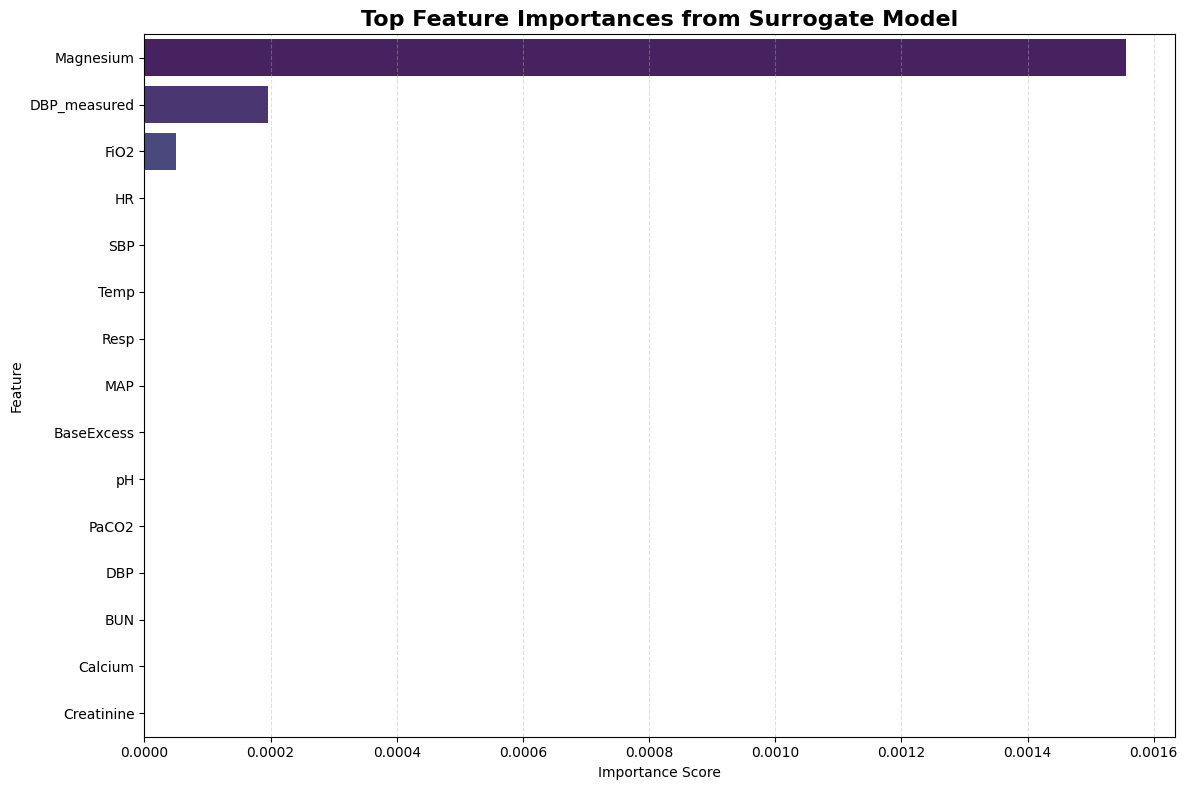

In [ ]:
feature_importance = surrogate_model.feature_importances_
min_len = min(len(feature_cols), len(feature_importance))
feature_cols_matched = feature_cols[:min_len]
feature_importance = feature_importance[:min_len]

importance_df = pd.DataFrame({
    "Feature": feature_cols_matched,
    "Importance": feature_importance
}).sort_values(by="Importance", ascending=False)

top_n = min(15, len(importance_df))
plt.figure(figsize=(12, 8))
sns.barplot(x="Importance", y="Feature", data=importance_df.head(top_n), palette='viridis')

plt.title("Top Feature Importances from Surrogate Model", fontsize=16, weight='bold')
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


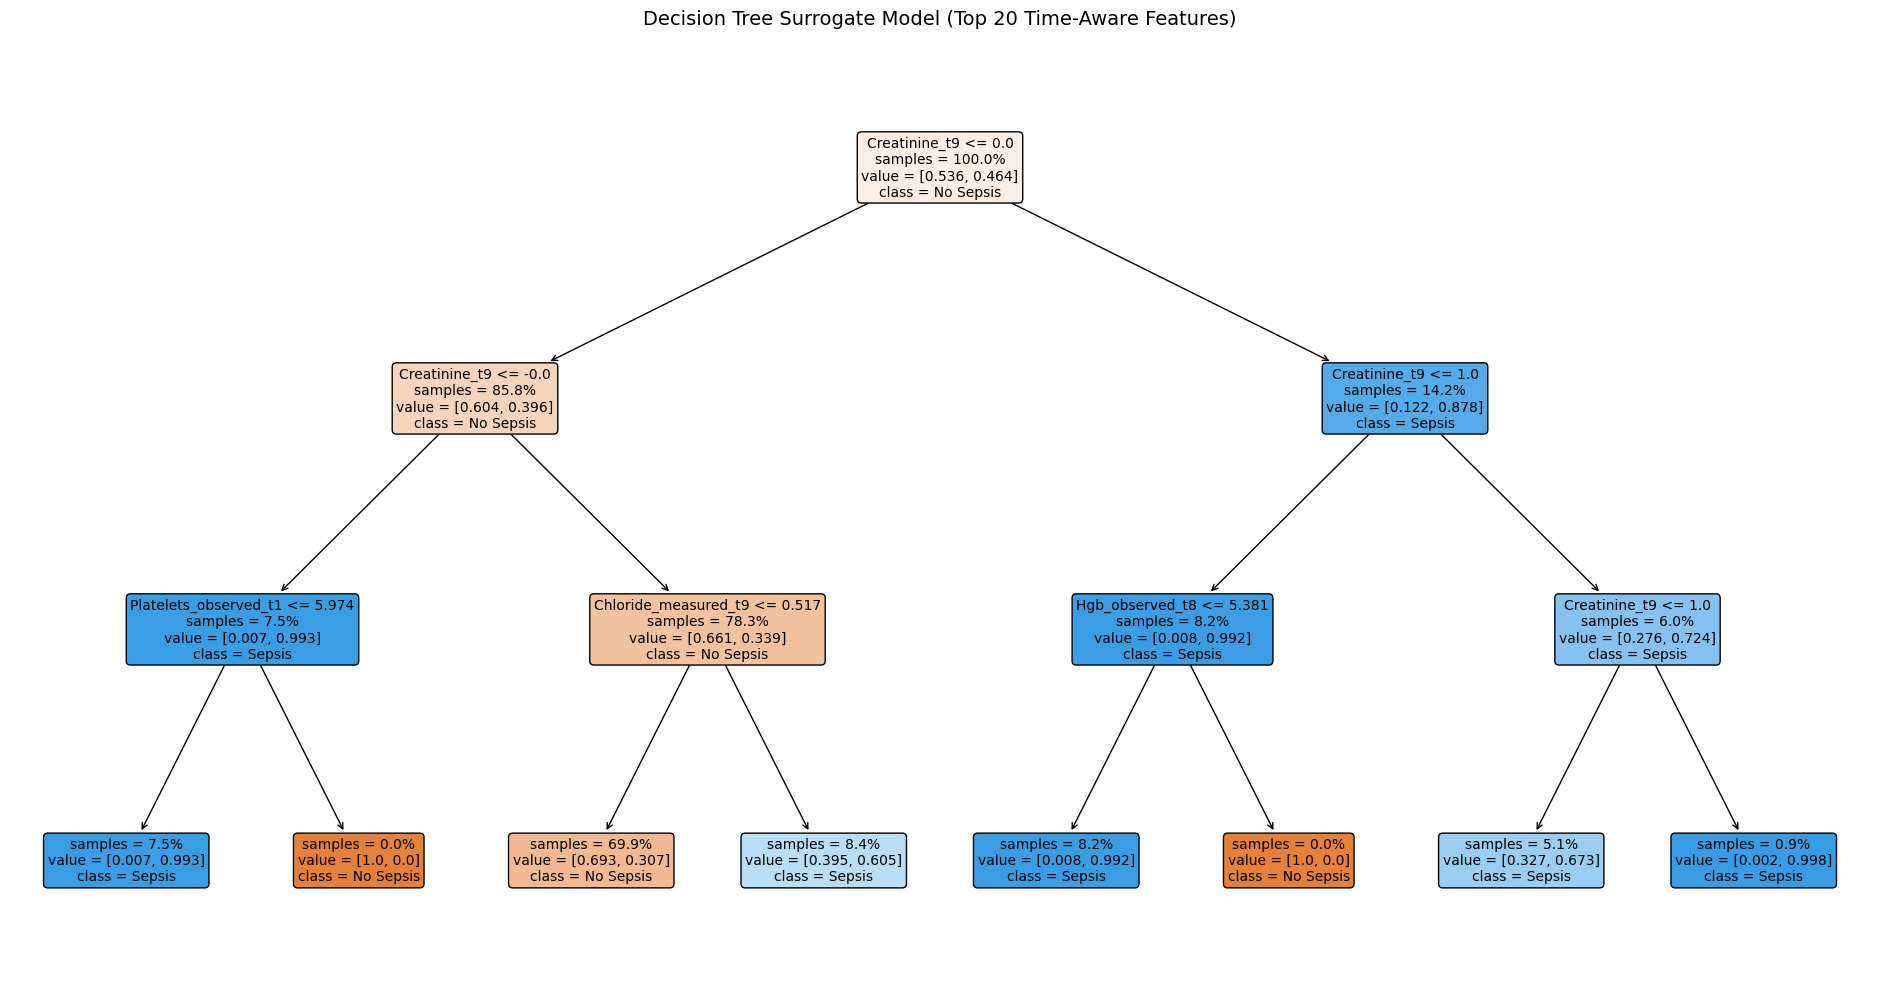

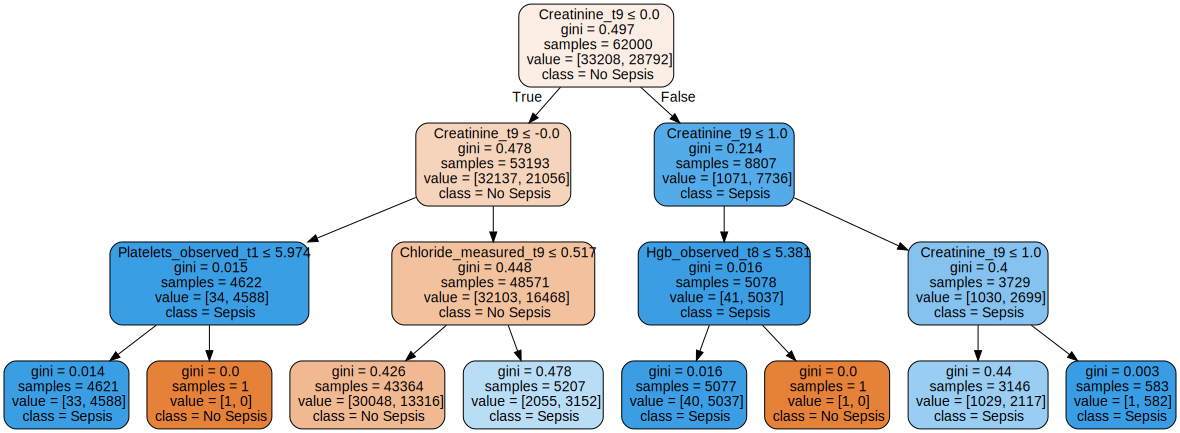

In [ ]:
feature_names = [f"{feat}_t{timestep}"
                 for timestep in range(X_train.shape[1])
                 for feat in feature_cols]

full_feature_importance = surrogate_model.feature_importances_
top_features = np.argsort(full_feature_importance)[-20:]

top_feature_names = [feature_names[i] for i in top_features]

X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_train_top = X_train_flat[:, top_features]

from sklearn.tree import DecisionTreeClassifier, plot_tree
surrogate_top = DecisionTreeClassifier(max_depth=3, random_state=42)
surrogate_top.fit(X_train_top, train_predictions_class)

plt.figure(figsize=(24, 12))
plot_tree(surrogate_top,
          filled=True,
          feature_names=top_feature_names,
          class_names=["No Sepsis", "Sepsis"],
          rounded=True,
          proportion=True,
          fontsize=10,
          impurity=False)
plt.title("Decision Tree Surrogate Model (Top 20 Time-Aware Features)", pad=20, fontsize=14)
plt.show()

from sklearn.tree import export_graphviz
import graphviz

dot_data = export_graphviz(surrogate_top,
                          out_file=None,
                          feature_names=top_feature_names,
                          class_names=["No Sepsis", "Sepsis"],
                          filled=True,
                          rounded=True,
                          special_characters=True)

graph = graphviz.Source(dot_data)
graph.render("sepsis_surrogate_tree", format='png', cleanup=True)
display(graph)


### **Glopal Model Agnostic PFI**

In [ ]:
def compute_custom_pfi(model, X, y, metric_fn=roc_auc_score):
    baseline_pred = model.predict(X, verbose=0).ravel()
    baseline_score = metric_fn(y, baseline_pred)

    n_features = X.shape[2]
    importances = []

    for i in tqdm(range(n_features), desc="Permuting features"):
        X_permuted = X.copy()

        # Shuffle feature i across samples (but keep timestep structure)
        for t in range(X.shape[1]):
            np.random.shuffle(X_permuted[:, t, i])

        permuted_pred = model.predict(X_permuted, verbose=0).ravel()
        permuted_score = metric_fn(y, permuted_pred)

        # Importance is the drop in score
        importance = baseline_score - permuted_score
        importances.append(importance)

    return importances, baseline_score


In [ ]:
def compute_custom_pfi(model, X, y, metric_fn=roc_auc_score):
    print("\n[INFO] Computing baseline AUC...")
    baseline_pred = model.predict(X, verbose=0).ravel()
    baseline_score = metric_fn(y, baseline_pred)
    print(f"[INFO] Baseline AUC = {baseline_score:.4f}")

    n_features = X.shape[2]
    importances = []

    print("[INFO] Permuting each feature across all timesteps...")
    for i in tqdm(range(n_features), desc="Permuting features"):
        X_permuted = X.copy()

        # Shuffle feature i across all samples, for each timestep
        for t in range(X.shape[1]):
            np.random.shuffle(X_permuted[:, t, i])

        permuted_pred = model.predict(X_permuted, verbose=0).ravel()
        permuted_score = metric_fn(y, permuted_pred)
        importances.append(baseline_score - permuted_score)

    return importances, baseline_score


pfi_scores, baseline_auc = compute_custom_pfi(model, X_test, y_test)

true_feature_cols = feature_cols

if len(true_feature_cols) != len(pfi_scores):
    print("[WARNING] Feature name and importance length mismatch! Fixing by truncation...")
    min_len = min(len(true_feature_cols), len(pfi_scores))
    true_feature_cols = true_feature_cols[:min_len]
    pfi_scores = pfi_scores[:min_len]


pfi_df = pd.DataFrame({
    "Feature": true_feature_cols,
    "Importance": pfi_scores
}).sort_values("Importance", ascending=False)
pfi_scores, baseline_auc = compute_custom_pfi(model, X_test, y_test)
true_feature_cols = feature_cols

if len(true_feature_cols) != len(pfi_scores):
    print("[WARNING] Feature name and importance length mismatch! Fixing by truncation...")
    min_len = min(len(true_feature_cols), len(pfi_scores))
    true_feature_cols = true_feature_cols[:min_len]
    pfi_scores = pfi_scores[:min_len]

pfi_df = pd.DataFrame({
    "Feature": true_feature_cols,
    "Importance": pfi_scores
}).sort_values("Importance", ascending=False)




[INFO] Computing baseline AUC...
[INFO] Baseline AUC = 0.9593
[INFO] Permuting each feature across all timesteps...


Permuting features: 100%|██████████| 51/51 [01:53<00:00,  2.23s/it]


[WARNING] Feature name and importance length mismatch! Fixing by truncation...

[INFO] Computing baseline AUC...
[INFO] Baseline AUC = 0.9593
[INFO] Permuting each feature across all timesteps...


Permuting features: 100%|██████████| 51/51 [01:54<00:00,  2.24s/it]

[WARNING] Feature name and importance length mismatch! Fixing by truncation...


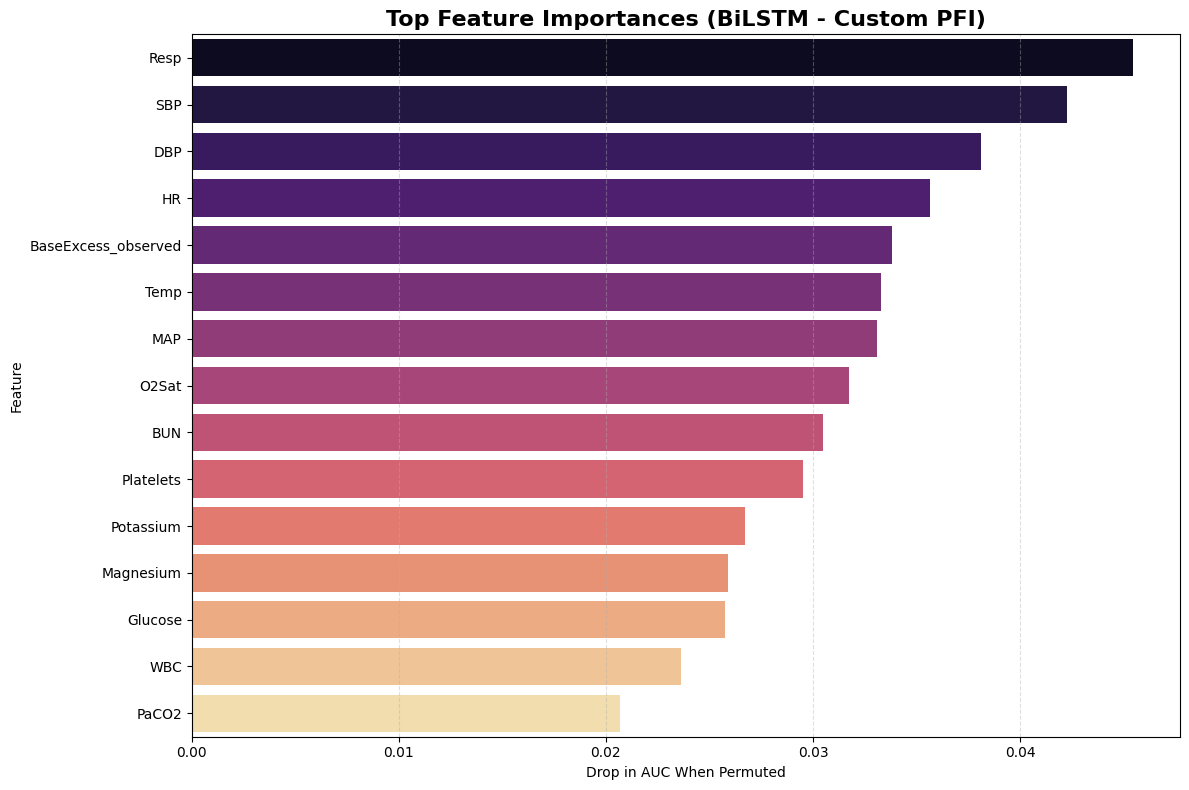

In [ ]:
top_n = 15
plt.figure(figsize=(12, 8))
sns.barplot(x="Importance", y="Feature", data=pfi_df.head(top_n), palette='magma')
plt.title("Top Feature Importances (BiLSTM - Custom PFI)", fontsize=16, weight='bold')
plt.xlabel("Drop in AUC When Permuted")
plt.ylabel("Feature")
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


In [ ]:
def get_top_features(model, X, y, feature_names, n_features=10):
    print("Calculating feature importances...")


    baseline_score = accuracy_score(y, model.predict(X).round())

    feature_importances = np.zeros(X.shape[2])

    for feat_idx in tqdm(range(X.shape[2])):
        X_permuted = X.copy()
        # Permute the feature across all timesteps
        for t in range(X.shape[1]):
            X_permuted[:, t, feat_idx] = np.random.permutation(X_permuted[:, t, feat_idx])

        permuted_score = accuracy_score(y, model.predict(X_permuted).round())
        feature_importances[feat_idx] = baseline_score - permuted_score

    sorted_idx = np.argsort(feature_importances)[::-1]
    top_indices = sorted_idx[:n_features]
    top_features = [(feature_names[i], feature_importances[i])
                   for i in top_indices]

    print("\nTop 10 Important Features:")
    for i, (feat, imp) in enumerate(top_features, 1):
        print(f"{i}. {feat}: {imp:.4f}")

    return top_indices, feature_importances

In [ ]:
# Cell 3: Execute feature importance calculation
print("Starting feature importance calculation...")
top_indices, feature_importances = get_top_features(
    model=model,
    X=X_test,
    y=y_test,
    feature_names=feature_cols,
    n_features=10
)

Starting feature importance calculation...
Calculating feature importances...
719/719 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


  0%|          | 0/51 [00:00<?, ?it/s]

719/719 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


  2%|▏         | 1/51 [00:02<01:53,  2.27s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


  4%|▍         | 2/51 [00:04<01:51,  2.28s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


  6%|▌         | 3/51 [00:06<01:51,  2.32s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


  8%|▊         | 4/51 [00:09<01:48,  2.30s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 10%|▉         | 5/51 [00:11<01:45,  2.28s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 12%|█▏        | 6/51 [00:13<01:42,  2.28s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 14%|█▎        | 7/51 [00:15<01:39,  2.27s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 16%|█▌        | 8/51 [00:18<01:37,  2.27s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 18%|█▊        | 9/51 [00:20<01:37,  2.33s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 20%|█▉        | 10/51 [00:22<01:34,  2.31s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 22%|██▏       | 11/51 [00:25<01:32,  2.31s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 24%|██▎       | 12/51 [00:27<01:29,  2.29s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 25%|██▌       | 13/51 [00:29<01:26,  2.28s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 27%|██▋       | 14/51 [00:32<01:24,  2.29s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 29%|██▉       | 15/51 [00:34<01:22,  2.29s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 31%|███▏      | 16/51 [00:36<01:19,  2.28s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 33%|███▎      | 17/51 [00:38<01:17,  2.28s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 35%|███▌      | 18/51 [00:41<01:15,  2.28s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 37%|███▋      | 19/51 [00:43<01:12,  2.27s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 39%|███▉      | 20/51 [00:45<01:10,  2.28s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 41%|████      | 21/51 [00:48<01:08,  2.27s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 43%|████▎     | 22/51 [00:50<01:06,  2.28s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 45%|████▌     | 23/51 [00:52<01:05,  2.34s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 47%|████▋     | 24/51 [00:55<01:02,  2.33s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 49%|████▉     | 25/51 [00:57<01:00,  2.31s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 51%|█████     | 26/51 [00:59<00:57,  2.30s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 53%|█████▎    | 27/51 [01:01<00:55,  2.31s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 55%|█████▍    | 28/51 [01:04<00:53,  2.31s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 57%|█████▋    | 29/51 [01:06<00:50,  2.31s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 59%|█████▉    | 30/51 [01:08<00:48,  2.32s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 61%|██████    | 31/51 [01:11<00:46,  2.31s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 63%|██████▎   | 32/51 [01:13<00:43,  2.31s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 65%|██████▍   | 33/51 [01:15<00:41,  2.33s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 67%|██████▋   | 34/51 [01:18<00:39,  2.32s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 69%|██████▊   | 35/51 [01:20<00:37,  2.31s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 71%|███████   | 36/51 [01:22<00:35,  2.34s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 73%|███████▎  | 37/51 [01:25<00:33,  2.37s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 75%|███████▍  | 38/51 [01:27<00:30,  2.36s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 76%|███████▋  | 39/51 [01:29<00:28,  2.34s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 78%|███████▊  | 40/51 [01:32<00:25,  2.32s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 80%|████████  | 41/51 [01:34<00:23,  2.32s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 82%|████████▏ | 42/51 [01:36<00:20,  2.31s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 84%|████████▍ | 43/51 [01:39<00:18,  2.29s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 86%|████████▋ | 44/51 [01:41<00:16,  2.29s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 88%|████████▊ | 45/51 [01:43<00:13,  2.30s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 90%|█████████ | 46/51 [01:46<00:11,  2.31s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 92%|█████████▏| 47/51 [01:48<00:09,  2.32s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 94%|█████████▍| 48/51 [01:50<00:06,  2.32s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 96%|█████████▌| 49/51 [01:52<00:04,  2.31s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


 98%|█████████▊| 50/51 [01:55<00:02,  2.37s/it]

719/719 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


100%|██████████| 51/51 [01:57<00:00,  2.31s/it]


Top 10 Important Features:
1. SBP: 0.0465
2. Resp: 0.0420
3. BaseExcess_observed: 0.0395
4. Temp: 0.0364
5. HR: 0.0362
6. DBP: 0.0342
7. MAP: 0.0328
8. BUN: 0.0319
9. O2Sat: 0.0301
10. Platelets: 0.0268


### **ALE**

In [ ]:
def compute_ale(model, X, feature_idx, n_bins=20, n_samples=500):
    """Compute ALE values for a specific feature across all timesteps"""
    if len(X) > n_samples:
        sample_indices = np.random.choice(len(X), n_samples, replace=False)
        X_sample = X[sample_indices]
    else:
        X_sample = X

    n_timesteps = X.shape[1]
    ale_values_per_timestep = []
    bin_centers_per_timestep = []

    for t in range(n_timesteps):
        feature_values = X_sample[:, t, feature_idx]
        percentiles = np.linspace(0, 100, n_bins + 1)
        bin_edges = np.percentile(feature_values, percentiles)
        bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

        ale = np.zeros(len(bin_edges) - 1)
        local_effects = []

        for i in range(len(bin_edges) - 1):
            lower, upper = bin_edges[i], bin_edges[i + 1]

            X_lower = X_sample.copy()
            X_upper = X_sample.copy()
            X_lower[:, t, feature_idx] = lower
            X_upper[:, t, feature_idx] = upper

            pred_lower = model.predict(X_lower, verbose=0).flatten()
            pred_upper = model.predict(X_upper, verbose=0).flatten()

            local_diff = pred_upper - pred_lower
            local_effects.append(local_diff)

        ale = np.mean(np.array(local_effects), axis=1)
        ale = np.cumsum(ale) - np.mean(ale)

        ale_values_per_timestep.append(ale)
        bin_centers_per_timestep.append(bin_centers)

    return bin_centers_per_timestep, ale_values_per_timestep

In [ ]:
def plot_ale_comparison(model, X_class0, X_class1, feature_names, feature_idx,
                       feature_name, n_bins=15, n_samples=500):
    """Plot side-by-side ALE comparison for a feature"""
    print(f"Computing ALE plots for feature: {feature_name}...")

    bins0, ale0 = compute_ale(model, X_class0, feature_idx, n_bins, n_samples)
    bins1, ale1 = compute_ale(model, X_class1, feature_idx, n_bins, n_samples)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
    fig.suptitle(f'ALE Analysis for {feature_name}', fontsize=16, y=1.05)

    for t in range(len(ale0)):
        ax1.plot(bins0[t], ale0[t], label=f'Timestep {t+1}', alpha=0.7)
    ax1.set_title('Effect on Non-Sepsis Predictions', fontsize=14)
    ax1.set_xlabel(f'Feature Value', fontsize=12)
    ax1.set_ylabel('Effect on Model Output', fontsize=12)
    ax1.axhline(0, color='gray', linestyle='--', linewidth=0.5)
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    # Plot for class 1 (Sepsis)
    for t in range(len(ale1)):
        ax2.plot(bins1[t], ale1[t], label=f'Timestep {t+1}', alpha=0.7)
    ax2.set_title('Effect on Sepsis Predictions', fontsize=14)
    ax2.set_xlabel(f'Feature Value', fontsize=12)
    ax2.set_ylabel('Effect on Model Output', fontsize=12)
    ax2.axhline(0, color='gray', linestyle='--', linewidth=0.5)
    ax2.grid(True, alpha=0.3)
    ax2.legend()

    plt.tight_layout()
    plt.show()

    print("ALE plot generation completed!")

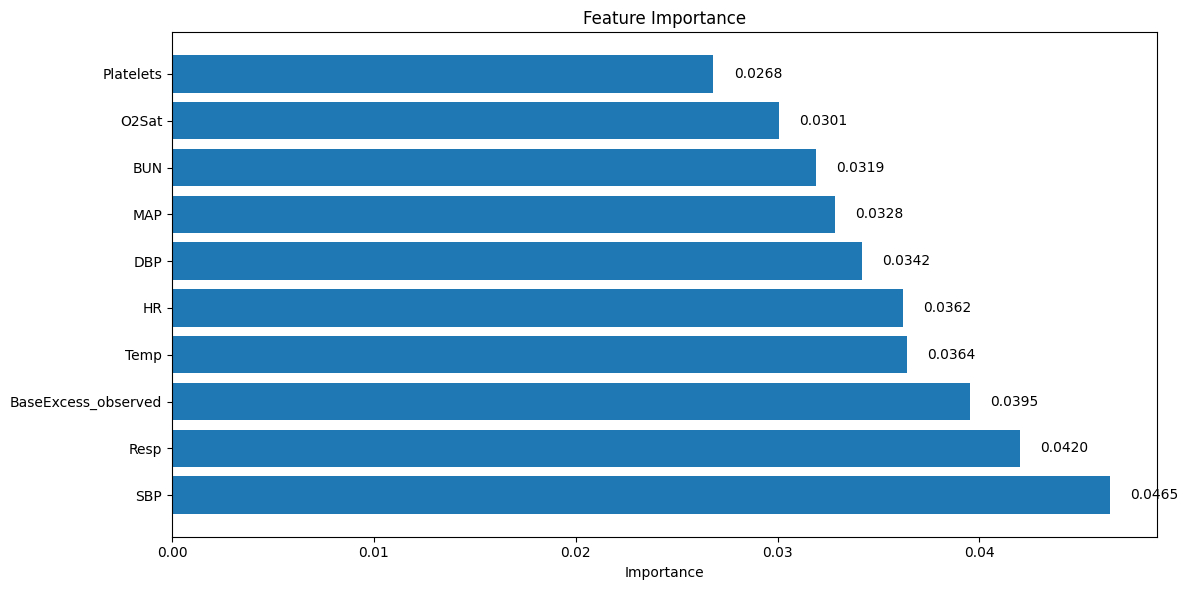

In [ ]:
def plot_feature_importance(feature_names, importances, top_indices):
    """Plot feature importance for top features"""
    top_features = [feature_names[i] for i in top_indices]
    top_importances = [importances[i] for i in top_indices]

    plt.figure(figsize=(12, 6))
    bars = plt.barh(range(len(top_features)), top_importances, align='center')
    plt.yticks(range(len(top_features)), top_features)
    plt.xlabel('Importance')
    plt.title('Feature Importance')

    # Add value labels on bars
    for i, v in enumerate(top_importances):
        plt.text(v + 0.001, i, f"{v:.4f}", va='center')

    plt.tight_layout()
    plt.show()

# Cell 7: Execute feature importance visualization
plot_feature_importance(feature_cols, feature_importances, top_indices)

In [ ]:
def create_interactive_ale_analysis(model, X_test, y_test, feature_cols, top_indices):
    X_class0 = X_test[y_test == 0]
    X_class1 = X_test[y_test == 1]


    feature_options = [(f"{i+1}. {feature_cols[idx]} ({feature_importances[idx]:.4f})")
                      for i, idx in enumerate(top_indices)]

    feature_dropdown = widgets.Dropdown(
        options=feature_options,
        value=feature_options[0],
        description='Select Feature:',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='50%')
    )

    # Create sliders for bins and sample size
    bins_slider = widgets.IntSlider(
        value=15,
        min=5,
        max=30,
        step=5,
        description='Number of Bins:',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='40%')
    )

    samples_slider = widgets.IntSlider(
        value=500,
        min=100,
        max=1000,
        step=100,
        description='Sample Size:',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='40%')
    )

    out = widgets.Output()

    def update_visualization(change):
        with out:
            clear_output(wait=True)

            selected_idx = int(feature_dropdown.value.split('.')[0]) - 1
            feature_idx = top_indices[selected_idx]
            feature_name = feature_cols[feature_idx]

            # Generate ALE plots
            plot_ale_comparison(
                model=model,
                X_class0=X_class0,
                X_class1=X_class1,
                feature_names=feature_cols,
                feature_idx=feature_idx,
                feature_name=feature_name,
                n_bins=bins_slider.value,
                n_samples=samples_slider.value
            )

    run_button = widgets.Button(
        description='Generate ALE Plots',
        button_style='primary',
        tooltip='Click to generate ALE plots for selected feature',
        layout=widgets.Layout(width='30%')
    )

    run_button.on_click(update_visualization)

    # Display widgets
    display(widgets.VBox([
        widgets.HBox([feature_dropdown]),
        widgets.HBox([bins_slider, samples_slider]),
        run_button,
        out
    ]))

In [ ]:
print("Launching interactive feature analysis tool...")
create_interactive_ale_analysis(
    model=model,
    X_test=X_test,
    y_test=y_test,
    feature_cols=feature_cols,
    top_indices=top_indices
)
print("Click 'Generate ALE Plots' to visualize feature effects")

Launching interactive feature analysis tool...


Click 'Generate ALE Plots' to visualize feature effects


In [ ]:
pip install shap


Note: you may need to restart the kernel to use updated packages.


719/719 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Analyzing 10 high-risk samples...


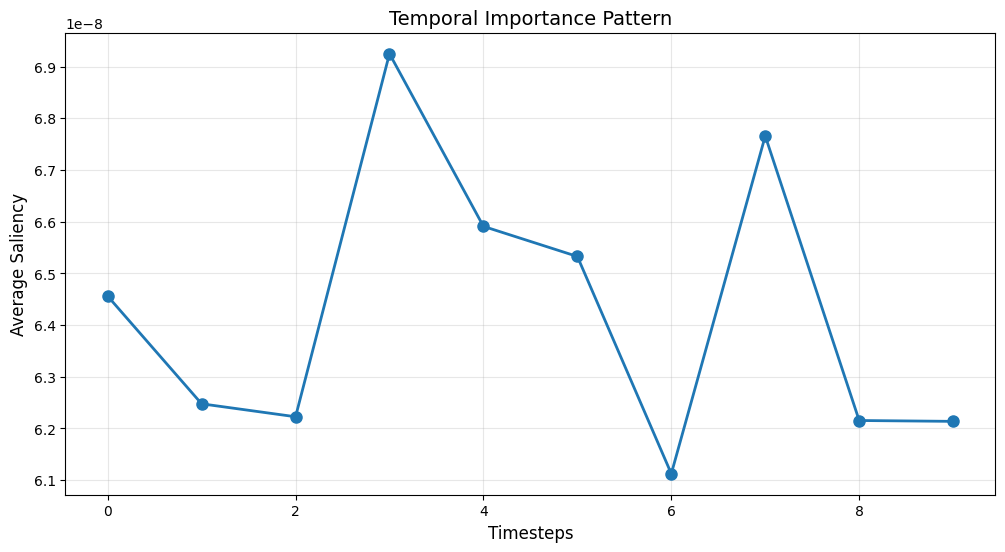

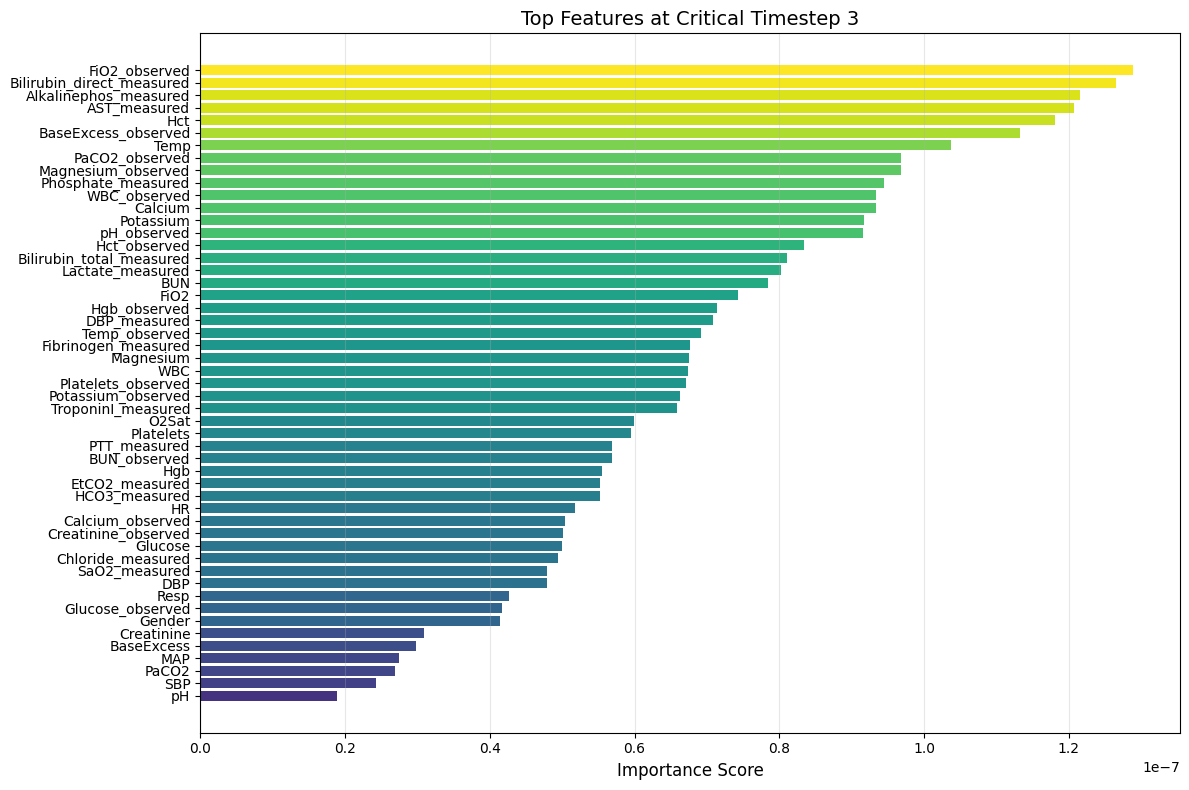

In [ ]:
def Critical_time_steps(model, X_sample, feature_cols):
    """
    Visualizes temporal and feature importance for sequential models

    Parameters:
    - model: Trained BiLSTM model
    - X_sample: Input samples (shape: [n_samples, timesteps, n_features])
    - feature_cols: List of feature names
    """
    # Convert to numpy if it's a tensor
    if tf.is_tensor(X_sample):
        X_sample = X_sample.numpy()

    # Handle single sample case
    if len(X_sample.shape) == 2:
        X_sample = np.expand_dims(X_sample, axis=0)

    # Calculate gradients
    X_sample_tensor = tf.convert_to_tensor(X_sample, dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(X_sample_tensor)
        predictions = model(X_sample_tensor)
    grads = tape.gradient(predictions, X_sample_tensor)

    # Convert gradients to numpy
    grads = grads.numpy()

    # Aggregate across samples
    saliency = np.mean(np.abs(grads), axis=(0,2))  # Mean across samples and features

    # Plot temporal pattern
    plt.figure(figsize=(12, 6))
    plt.plot(saliency, 'o-', linewidth=2, markersize=8)
    plt.xlabel('Timesteps', fontsize=12)
    plt.ylabel('Average Saliency', fontsize=12)
    plt.title('Temporal Importance Pattern', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.show()

    # Feature importance at critical timestep
    critical_timestep = np.argmax(saliency)
    feature_importance = np.mean(np.abs(grads[:, critical_timestep, :]), axis=0)

    # Sort features by importance
    sorted_idx = np.argsort(feature_importance)

    # Plot feature importance
    plt.figure(figsize=(12, 8))
    colors = plt.cm.viridis(feature_importance[sorted_idx]/np.max(feature_importance))
    plt.barh(np.array(feature_cols)[sorted_idx],
             feature_importance[sorted_idx],
             color=colors)
    plt.title(f'Top Features at Critical Timestep {critical_timestep}', fontsize=14)
    plt.xlabel('Importance Score', fontsize=12)
    plt.grid(True, axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

# Example usage with proper high-risk index handling:
y_pred = model.predict(X_test).flatten()
high_risk_idx = np.argsort(y_pred)[-10:]  # Top 10 highest risk samples
high_risk_samples = X_test[high_risk_idx]  # Get numpy array first

print(f"Analyzing {len(high_risk_samples)} high-risk samples...")
Critical_time_steps(model, high_risk_samples, feature_cols)

In [ ]:
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
def generate_dynamic_counterfactuals(model, X_sample, feature_cols, X_train=None, target_class=1):
    """
    Generates dynamic counterfactuals with data-driven normal ranges

    Parameters:
    - model: Trained BiLSTM model
    - X_sample: Input sample (shape: [1, timesteps, n_features])
    - feature_cols: List of feature names
    - X_train: Training data for calculating normal ranges (optional)
    - target_class: Target prediction class
    """
    # Dynamic normal range calculation
    def get_dynamic_normal_ranges():
        if X_train is not None:
            normal_ranges = {}
            for f_idx, feat in enumerate(feature_cols):
                # Use 5th-95th percentiles from training data
                values = X_train[:, :, f_idx].flatten()
                normal_ranges[feat] = (
                    np.percentile(values, 5),  # Lower bound
                    np.percentile(values, 95)  # Upper bound
                )
            return normal_ranges
        else:
            # Fallback to clinical defaults
            return {
                'Lactate': (0.5, 2.0),
                'HR': (60, 100),
                'SBP': (90, 120),
                'DBP': (60, 80),
                'RR': (12, 20),
                'Temp': (36.0, 37.5),
                'WBC': (4.0, 10.0)
            }

    normal_ranges = get_dynamic_normal_ranges()

    # Get baseline prediction
    original_prob = model.predict(X_sample, verbose=0)[0,0]

    # Initialize impact matrix
    impact = np.zeros_like(X_sample)

    # Calculate counterfactuals
    for t in range(X_sample.shape[1]):
        for f_idx, feat in enumerate(feature_cols):
            original_val = X_sample[0,t,f_idx]
            lower, upper = normal_ranges.get(feat, (0, 1))

            # Set to midpoint of normal range
            X_sample[0,t,f_idx] = (lower + upper) / 2
            new_prob = model.predict(X_sample, verbose=0)[0,0]
            impact[0,t,f_idx] = original_prob - new_prob
            X_sample[0,t,f_idx] = original_val  # Reset

    # Create interactive plot
    fig = go.Figure()

    # Add temporal impact trace
    max_impact = np.max(np.abs(impact[0]), axis=1)
    fig.add_trace(go.Scatter(
        x=np.arange(X_sample.shape[1]),
        y=max_impact,
        mode='lines+markers',
        name='Max Impact',
        line=dict(color='firebrick', width=3),
        marker=dict(size=8),
        hovertemplate='Hour %{x}<br>Impact: %{y:.2f}<extra></extra>'
    ))

    # Add heatmap
    fig.add_trace(go.Heatmap(
        z=impact[0].T,
        x=np.arange(X_sample.shape[1]),
        y=[f"● {feat}" for feat in feature_cols],
        colorscale='RdBu',
        zmid=0,
        hoverongaps=False,
        hovertemplate=(
            "Feature: %{y}<br>"
            "Hour: %{x}<br>"
            "Risk Change: %{z:.2f}<br>"
            "Normal Range: %{customdata[0]:.1f}-%{customdata[1]:.1f}"
            "<extra></extra>"
        ),
        customdata=np.array([
            [[normal_ranges[feat][0], normal_ranges[feat][1]]
             for _ in range(X_sample.shape[1])]
            for feat in feature_cols
        ])
    ))

    # Add normal range annotations
    annotations = []
    for f_idx, feat in enumerate(feature_cols):
        annotations.append(dict(
            xref='paper', yref='y',
            x=1.05, y=f_idx,
            text=f"{normal_ranges[feat][0]:.1f}-{normal_ranges[feat][1]:.1f}",
            showarrow=False,
            font=dict(size=10)
        ))

    # Layout configuration
    fig.update_layout(
        title='Dynamic Counterfactual Analysis',
        height=800,
        xaxis_title='Hours Before Prediction',
        yaxis_title='Biomarkers',
        yaxis_autorange='reversed',
        xaxis=dict(tickmode='linear', dtick=6),
        hoverlabel=dict(bgcolor='white', font_size=12),
        margin=dict(l=100, r=150),
        annotations=annotations
    )

    # Add normal range title
    fig.add_annotation(
        xref='paper', yref='paper',
        x=1.08, y=1,
        text="Normal Range",
        showarrow=False,
        font=dict(size=12, color='black'))

    fig.show()

    return impact, normal_ranges

# Example usage with dynamic ranges:
high_risk_idx = np.where(model.predict(X_test, verbose=0)[:,0] > 0.7)[0][0]
impact, ranges = generate_dynamic_counterfactuals(
    model=model,
    X_sample=X_test[high_risk_idx:high_risk_idx+1],
    feature_cols=feature_cols,
    X_train=X_train  # For calculating data-driven normal ranges
)

print("Calculated Normal Ranges:")
for feat, (lower, upper) in ranges.items():
    print(f"{feat}: {lower:.1f}-{upper:.1f}")

Calculated Normal Ranges:
HR: -1.4-1.9
O2Sat: -1.7-0.9
Temp: -1.6-2.0
SBP: -1.5-1.8
MAP: -1.4-1.7
DBP: -1.5-1.6
Resp: -1.3-2.2
BaseExcess: -0.8-0.9
FiO2: -0.5-0.5
pH: -1.0-1.2
PaCO2: -1.0-0.8
BUN: -1.3-1.0
Calcium: -0.7-1.0
Creatinine: -1.2-0.9
Glucose: -1.3-0.9
Magnesium: -1.2-1.0
Potassium: -1.1-1.1
Hct: -0.9-0.7
Hgb: -0.8-0.7
WBC: -1.2-1.4
Platelets: -1.0-0.8
Gender: 0.0-1.0
EtCO2_measured: -0.0-1.0
HCO3_measured: 0.0-0.0
SaO2_measured: 0.0-0.0
AST_measured: 0.0-0.0
Alkalinephos_measured: 0.0-0.0
Chloride_measured: 0.0-1.0
Bilirubin_direct_measured: 0.0-0.0
Lactate_measured: 0.0-0.0
Phosphate_measured: 0.0-0.0
Bilirubin_total_measured: 0.0-0.0
TroponinI_measured: 0.0-0.0
PTT_measured: 0.0-0.0
Fibrinogen_measured: 0.0-0.0
Temp_observed: 0.0-1.0
BaseExcess_observed: 0.0-1.0
FiO2_observed: -0.0-1.0
pH_observed: 0.0-1.0
PaCO2_observed: 0.0-1.0
BUN_observed: 0.0-1.0
Calcium_observed: 0.0-1.0
Creatinine_observed: 0.0-1.0
Glucose_observed: 0.0-1.0
Magnesium_observed: 0.0-1.0
Potassium_obse